In [1]:
%pylab inline
import pandas as pd
import torch
from pyro.contrib.brm import brm
from pyro.contrib.brm.priors import PriorEdit, prior
from pyro.contrib.brm.fit import marginals, print_model

Populating the interactive namespace from numpy and matplotlib


# Data

Here's a simple synthetic dataset. It was generated by `makedata.py`, which can be found in the same directory as this notebook.

In [2]:
df = pd.read_csv('out.csv')
df['c'] = df['c'].astype('category')

In [3]:
df.head()

,y,x,c
0,0.36,-1.54,B
1,1.10,-0.15,B
2,0.86,-0.14,B
3,-0.26,-0.56,A
4,0.39,-0.36,A


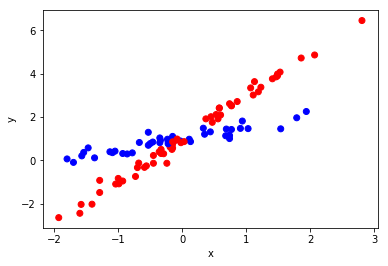

In [4]:
xlabel('x'); ylabel('y')
scatter(df['x'], df['y'], color=[dict(A='r', B='b')[c] for c in df['c']])

# BRMS

We can use brms to fit the model described by the formula `y ~ 1 + (-1 + x | c)`.

```
df <- read.csv('out.csv')
fit <- brm(bf(y ~ 1 + (-1 + x|c), center=0), data=df)
```

By default the following priors are used:

```
fit$prior
#                 prior class      coef group resp dpar nlpar bound
# 1                         b
# 2                         b Intercept
# 3 student_t(3, 0, 10)    sd
# 4                        sd               c
# 5                        sd         x     c
# 6 student_t(3, 0, 10) sigma
```

Here's a posterior summary after running the default inference procedure. (Outside of this notebook.)

```
fit$fit
#              mean se_mean   sd 2.5%  25%   50%   75% 97.5% n_eff Rhat
# b_Intercept  0.99    0.00 0.02 0.95 0.98  0.99  1.00  1.03  1498 1.00
# sd_c__x      2.70    0.14 1.63 0.85 1.44  2.20  3.55  6.85   135 1.04
# sigma        0.20    0.00 0.01 0.18 0.19  0.20  0.21  0.23  1052 1.00
# r_c[A,x]     1.97    0.00 0.03 1.92 1.96  1.97  1.99  2.03  3877 1.00
# r_c[B,x]     0.51    0.00 0.03 0.44 0.49  0.51  0.53  0.57  3031 1.00
# lp__        10.50    0.10 1.97 5.96 9.40 10.81 11.96 13.43   390 1.01
```

The means of the shared intercept (`b_Intercept`), per-group slopes (`r_c[A,x]` and `r_c[B,x]`) and the standard deviation of the response distribution (`sigma`) all are close to the true values used to generate the data. (Which were 1.0, 2.0, 0.5 and 0.2 respectively.)

It took ~40 seconds to compile the C++ model, then ~20 seconds to run 4 chains (in series), each collecting 2000 samples.

# BRMP

We can fit the same model using BRMP. We manually specify priors vaguely similar to those chosen by BRMS. It currently takes between ~1 and 3 minutes to generate 600 samples using NUTS.

In [5]:
fit = brm('y ~ 1 + (x | c)', df, prior_edits=[
    PriorEdit(('b',),            prior('Normal',     [0., 10.])),
    PriorEdit(('sd',),           prior('HalfCauchy', [10.])),
    PriorEdit(('resp', 'sigma'), prior('HalfCauchy', [10.])),
], iter=500, warmup=100)

Sample: 100%|██████████| 600/600 [02:27<00:00,  3.66it/s, step size=2.26e-02, acc. rate=0.967]


Some of the information available in the BRMS posterior summary (shown above) is available via the `print_marginals` helper. We see that, for the values shown, the system produces results similar to those produced by brms.

In [6]:
marginals(fit)

             mean    sd  2.5%   25%   50%   75% 97.5%
b_intercept  0.99  0.02  0.94  0.97  0.99  1.00  1.03
   r_c[A,x]  1.97  0.03  1.92  1.96  1.97  1.99  2.03
   r_c[B,x]  0.51  0.03  0.44  0.48  0.51  0.53  0.57
      sigma  0.20  0.01  0.18  0.19  0.20  0.21  0.23

# Appendix

In [7]:
print_model(fit)

Population
----------------------------------------
Coef Priors:
intercept       | Normal(mu=0.0, sigma=10.0)
Group 0
----------------------------------------
Factor: c
Levels: ['A', 'B']
Corr. Prior: None
S.D. Priors:
x               | HalfCauchy(scale=10.0)
Response
----------------------------------------
Family: Normal()
Link:
  Parameter: mu
  Function:  identity
Priors:
sigma           | HalfCauchy(scale=10.0)


In [8]:
print(fit.model.code)

def model(X, Z_0, J_0, y_obs=None):
    assert type(X) == torch.Tensor
    N = X.shape[0]
    M = 1
    assert X.shape == (N, M)
    b_0 = pyro.sample("b_0", dist.Normal(torch.tensor(0.0).expand([1]), torch.tensor(10.0).expand([1])).to_event(1))
    b = torch.cat([b_0])
    assert b.shape == (M,)
    mu = torch.mv(X, b)
    
    # [0] Categorical(name='c', levels=['A', 'B'])
    M_0 = 1 # Number of coeffs
    N_0 = 2 # Number of levels
    assert type(Z_0) == torch.Tensor
    assert Z_0.shape == (N, M_0) # N x 1
    assert type(J_0) == torch.Tensor
    assert J_0.shape == (N,)
    sd_0_0 = pyro.sample("sd_0_0", dist.HalfCauchy(torch.tensor(10.0).expand([1])).to_event(1))
    sd_0 = torch.cat([sd_0_0])
    assert sd_0.shape == (M_0,) # 1
    z_0 = pyro.sample("z_0", dist.Normal(torch.tensor(0.0).expand([1, 2]), torch.tensor(1.0).expand([1, 2])).to_event(2))
    assert z_0.shape == (M_0, N_0) # 1 x 2
    r_0 = (z_0 * sd_0.unsqueeze(1)).transpose(0, 1)
    assert r_0.shape == (N_0, M_0) #